The general autoencoder structure was taken from: https://www.tensorflow.org/tutorials/generative/autoencoder and used for this file

In [6]:
#Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from music21 import stream,note

In [7]:
#Read processed songs from file and store in an array
songs_reshaped = pd.read_csv('C:/Users/Amir/Documents/Graduate School/SEP788_789/Project/music_dataset-main/all_songs_no_time.csv',delimiter=',',header=None).to_numpy(dtype='float32')

#Reshape songs so that each sample has a length of 64 (4 beats)
songs = songs_reshaped.reshape(-1,64,128).astype('float32')

#Remove notes that occur <100 times to reduce sample size
songs = songs[:,:,30:90]
songs.shape

(5688, 64, 60)

In [8]:
#Delete any sample that may contain only zeros after resizing
zero_images = np.empty(0).astype('int')
for i in range(songs.shape[0]):
    if np.all(songs[i]==0):
        zero_images = np.append(zero_images,i)
songs_nz = np.delete(songs,zero_images,axis=0)

In [9]:
#Split the dataset into train and test. Keep random state=1 for repeatable results
x_train,x_test = train_test_split(songs_nz, test_size = 0.25, random_state = 1)


In [10]:
#Replaces -1 with 0.5. For use with Relu activation functions.
x_train_norm = np.where(x_train==-1,0.5,x_train)
x_test_norm = np.where(x_test==-1,0.5,x_test)

In [27]:
#The latent vector dimension to compress the input into
latent_dim = 1024

In [28]:
#Define the encoder model in a function
def encoder():
    model=tf.keras.Sequential()
    model.add(layers.InputLayer((64,60)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024,activation = 'tanh'))
    #model.add(layers.Dense(512,activation = 'tanh'))
    #model.add(layers.Dense(256,activation = 'tanh'))
    #model.add(layers.Dense(64,activation = 'tanh'))
    model.add(layers.Dense(latent_dim))
    return model


# enc.build()
# enc.summary()
# plot_model(enc,show_shapes=True)

In [29]:
#Define the decoder model in a function
def decoder():
    model=tf.keras.Sequential()
    model.add(layers.InputLayer(latent_dim))
    #model.add(layers.Dense(64,activation = 'tanh'))
    #model.add(layers.Dense(256, activation = 'tanh'))
    #model.add(layers.Dense(512,activation = 'tanh'))
    model.add(layers.Dense(1024, activation = 'tanh'))
    model.add(layers.Dense(64*60))
    model.add(layers.Reshape(target_shape = (64,60)))
    return model

# dec.build()
# dec.summary()
# plot_model(dec,show_shapes=True)

In [30]:
#Define a model class called Autoencoder that is trained
class Autoencoder(Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(Autoencoder,self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [31]:
#Call Autoencoder
enc = encoder()
dec = decoder()
autoencoder = Autoencoder(latent_dim, enc, dec)

#Create optimizer and set learning rate
opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)

#Compile model, set loss as mean squared error
autoencoder.compile(optimizer=opt, loss='mse')

In [32]:
#Define an early stop callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, mode = "min", min_delta = 5e-5, restore_best_weights = True)

#Train the model
autoencoder.fit(x_train, x_train, batch_size = 128, epochs=400,validation_data=(x_test, x_test), callbacks = [early_stop])

Epoch 1/400
33/33 [==============================] - 1s 19ms/step - loss: 0.0540 - val_loss: 0.0434
Epoch 2/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0375 - val_loss: 0.0337
Epoch 3/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0296 - val_loss: 0.0277
Epoch 4/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0247 - val_loss: 0.0239
Epoch 5/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0214 - val_loss: 0.0212
Epoch 6/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0190 - val_loss: 0.0192
Epoch 7/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0171 - val_loss: 0.0176
Epoch 8/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0155 - val_loss: 0.0162
Epoch 9/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0142 - val_loss: 0.0151
Epoch 10/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0131 - val_loss: 0.0141
Epoch 11

33/33 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 84/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 85/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 86/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 87/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 88/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 89/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 90/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 91/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 92/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 93/400


33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 165/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 166/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 167/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 168/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 169/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 170/400
33/33 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 171/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 172/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 173/400
33/33 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0025
Epoc

33/33 [==============================] - 0s 8ms/step - loss: 7.5740e-04 - val_loss: 0.0022
Epoch 243/400
33/33 [==============================] - 0s 7ms/step - loss: 7.5393e-04 - val_loss: 0.0022
Epoch 244/400
33/33 [==============================] - 0s 7ms/step - loss: 7.5231e-04 - val_loss: 0.0022
Epoch 245/400
33/33 [==============================] - 0s 7ms/step - loss: 7.5030e-04 - val_loss: 0.0022
Epoch 246/400
33/33 [==============================] - 0s 7ms/step - loss: 7.4794e-04 - val_loss: 0.0022
Epoch 247/400
33/33 [==============================] - 0s 7ms/step - loss: 7.4742e-04 - val_loss: 0.0022
Epoch 248/400
33/33 [==============================] - 0s 7ms/step - loss: 7.4264e-04 - val_loss: 0.0022
Epoch 249/400
33/33 [==============================] - 0s 8ms/step - loss: 7.3847e-04 - val_loss: 0.0022
Epoch 250/400
33/33 [==============================] - 0s 7ms/step - loss: 7.3525e-04 - val_loss: 0.0022
Epoch 251/400
33/33 [==============================] - 0s 7ms/step - 

33/33 [==============================] - 0s 8ms/step - loss: 6.0348e-04 - val_loss: 0.0020
Epoch 321/400
33/33 [==============================] - 0s 8ms/step - loss: 6.0118e-04 - val_loss: 0.0020
Epoch 322/400
33/33 [==============================] - 0s 7ms/step - loss: 5.9862e-04 - val_loss: 0.0020
Epoch 323/400
33/33 [==============================] - 0s 7ms/step - loss: 5.9971e-04 - val_loss: 0.0020
Epoch 324/400
33/33 [==============================] - 0s 7ms/step - loss: 5.9996e-04 - val_loss: 0.0020
Epoch 325/400
33/33 [==============================] - 0s 7ms/step - loss: 5.9866e-04 - val_loss: 0.0020
Epoch 326/400
33/33 [==============================] - 0s 7ms/step - loss: 5.9581e-04 - val_loss: 0.0020
Epoch 327/400
33/33 [==============================] - 0s 8ms/step - loss: 5.9292e-04 - val_loss: 0.0020
Epoch 328/400
33/33 [==============================] - 0s 7ms/step - loss: 5.9057e-04 - val_loss: 0.0020
Epoch 329/400
33/33 [==============================] - 0s 7ms/step - 

In [33]:
#Test the models performance by encoding test samples and reconstructing
encoded_sngs = autoencoder.encoder(x_test).numpy()
decoded_sngs = autoencoder.decoder(encoded_sngs).numpy()

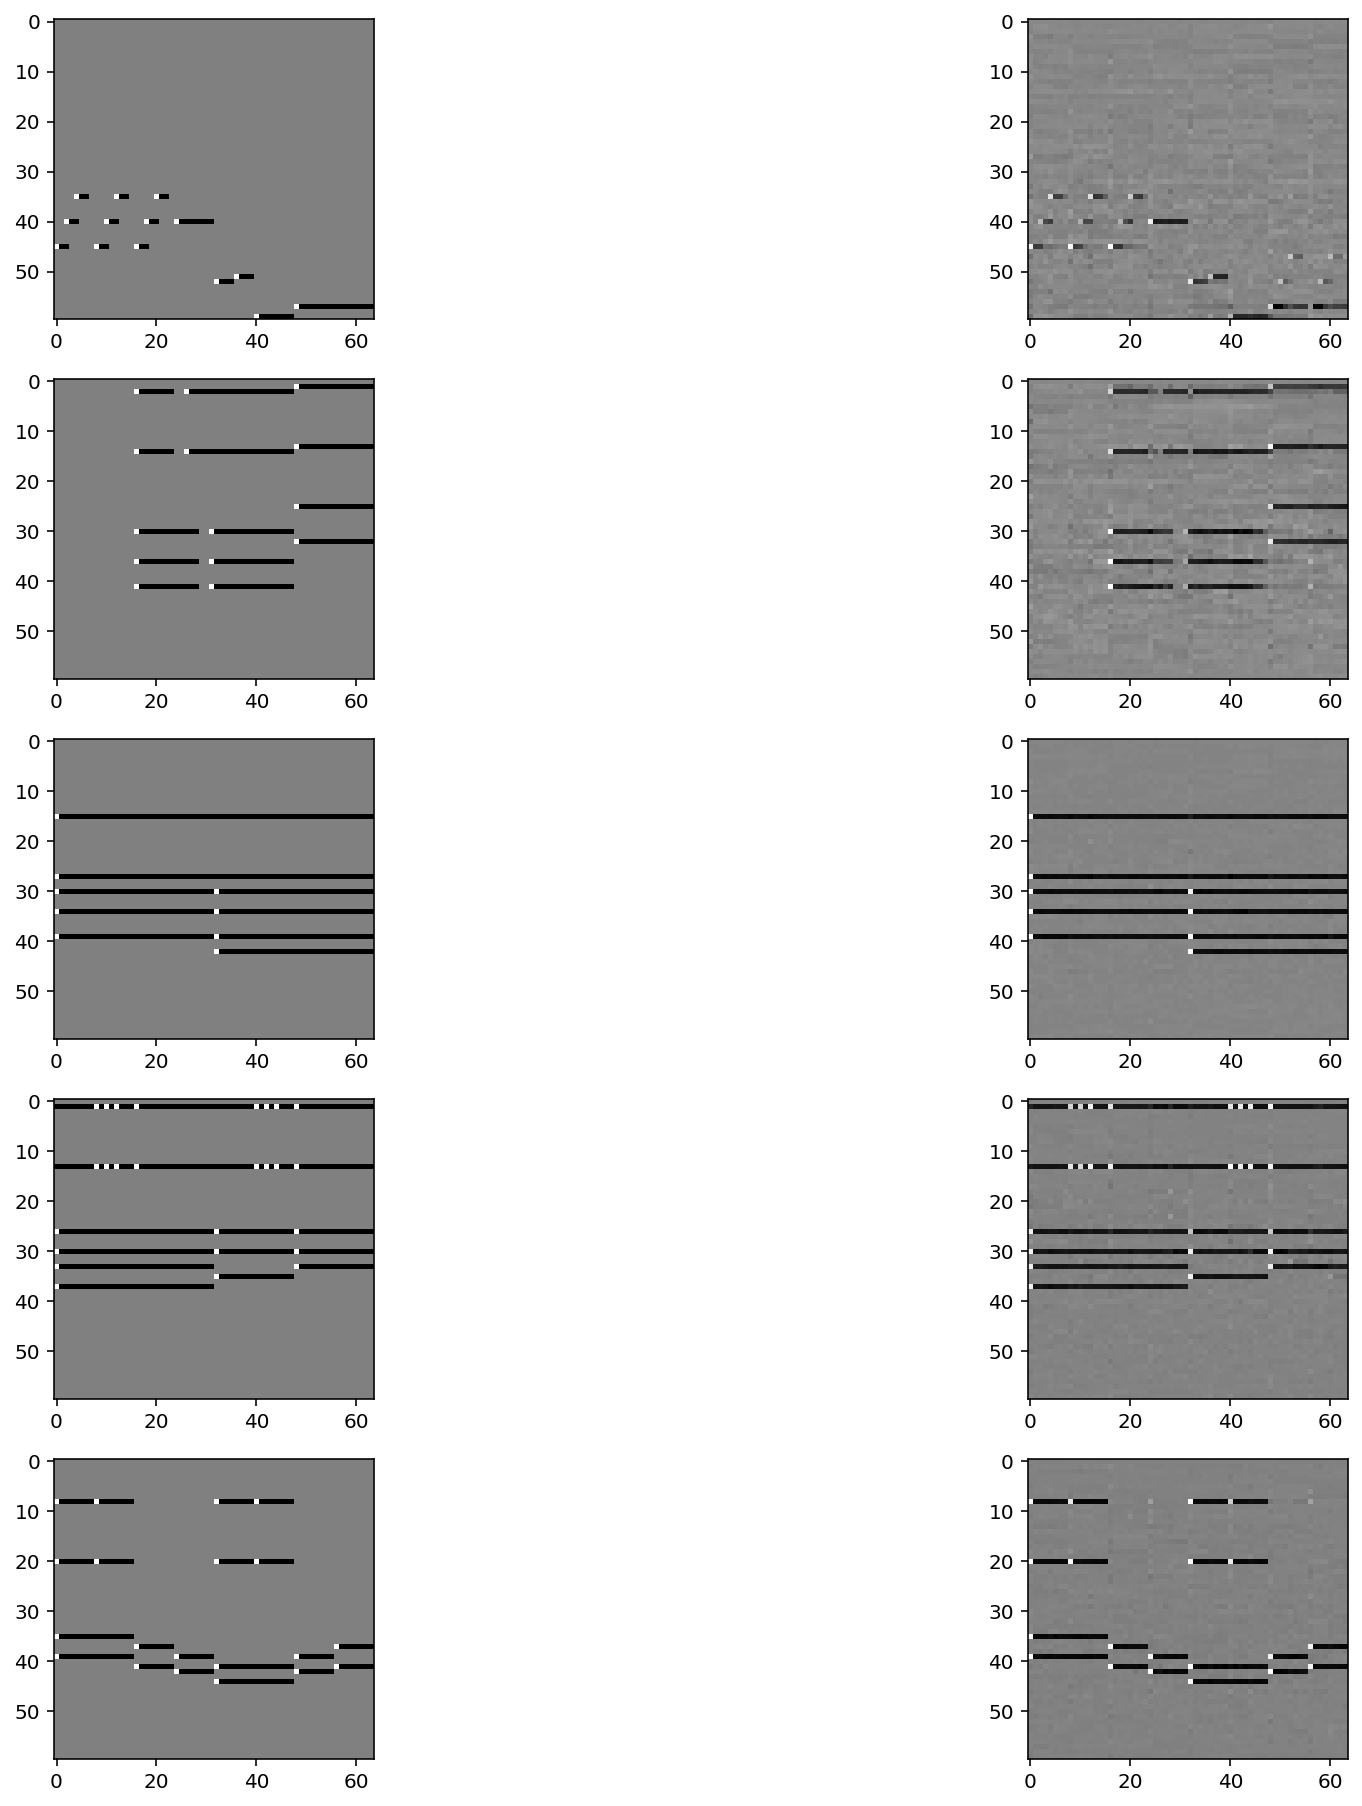

In [34]:
#Show first 5 original vs reconstructed samples
plt.figure(figsize=(16, 16))

for i in range(1,11,2):
    plt.subplot(5,2,i)
    plt.imshow(x_test[int((i-1)/2)].transpose(),cmap='gray')
    plt.subplot(5,2,i+1)
    plt.imshow(decoded_sngs[int((i-1)/2)].transpose(),cmap='gray')
#plt.imshow(decoded_sngs[1].transpose())

In [ ]:
#What happens if we apply a random seed to the decoder?
seed = tf.random.normal([10, latent_dim])
generated_songs = autoencoder.decoder(seed).numpy()
plt.imshow(generated_songs[0].transpose())
plt.show()